In [2132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

In [2133]:
df = pd.read_csv('../data/day_ahead_energy_prices.csv', delimiter=",")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [2134]:
SPLIT_DATE = df.index[int(0.18 * len(df))]


train = df.loc[df.index < SPLIT_DATE]
test = df.loc[df.index >= SPLIT_DATE]

train.shape, test.shape

((68782, 1), (15099, 1))

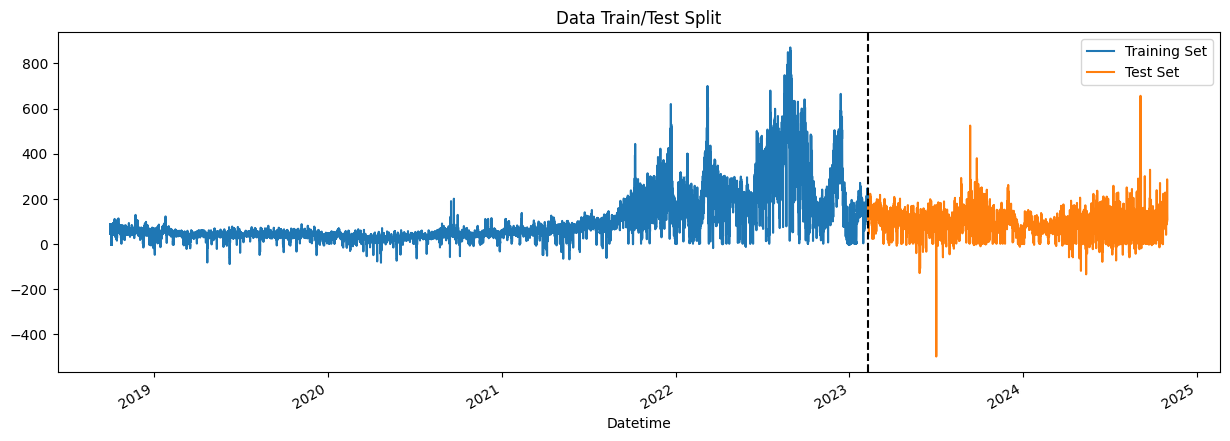

In [2135]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(SPLIT_DATE, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [2136]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,156.156667,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 02:00:00+00:00,47.59,2,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.451071
2018-10-01 01:00:00+00:00,47.38,1,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.451071
2018-10-01 00:00:00+00:00,51.41,0,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.451071


In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofyear', 'dayofweek', 'ma_3_hours','ma_6_hours','ma_1_days','ma_3_days','ma_7_days']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

best_params = {
    'base_score': float(0.20438597995798177),
    'colsample_bytree': float(0.932989723014941),
    'early_stopping_rounds': int(4),
    'gamma': float(0.0001751200398487085),
    'learning_rate': float(0.5),  # A high learning rate; consider adjusting based on model performance
    'max_depth': int(2),
    'min_child_weight': int(3),
    'n_estimators': int(5),
    'subsample': float(0.8159969087302229)
}

reg = xgb.XGBRegressor(
    base_score=best_params['base_score'],
    colsample_bytree=best_params['colsample_bytree'],
    early_stopping_rounds=best_params['early_stopping_rounds'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective='reg:squarederror',
)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=25)

[0]	validation_0-rmse:64.11544	validation_1-rmse:54.51642
[4]	validation_0-rmse:17.03710	validation_1-rmse:19.50444


XGBRegressor(base_score=0.20438597995798177, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.932989723014941, device=None,
             early_stopping_rounds=4, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0001751200398487085,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

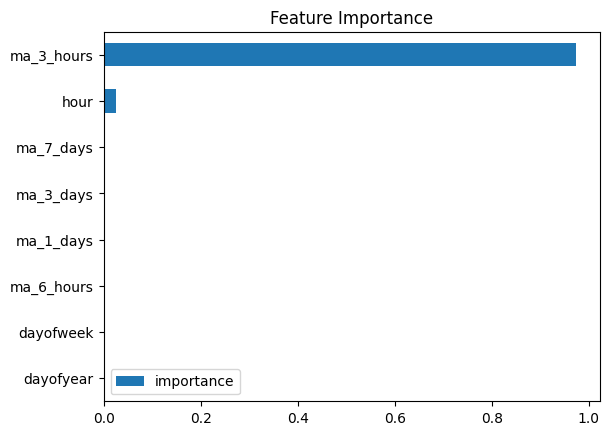

In [2138]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [2139]:
test['prediction'] = reg.predict(X_test)
test

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days,prediction
Datetime,,,,,,,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN,130.868530
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN,130.868530
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN,116.269272
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN,130.868530
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,156.156667,NaN,NaN,NaN,NaN,NaN,130.868530
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-09 00:00:00+00:00,118.36,0,3,40,6,116.313333,126.203333,129.418333,133.091667,121.858472,137.527440,109.533241
2023-02-08 23:00:00+00:00,109.56,23,2,39,6,114.346667,118.590000,129.283333,132.544583,121.578472,137.507798,116.269272
2023-02-08 22:00:00+00:00,118.94,22,2,39,6,115.620000,116.318333,129.880833,132.585833,121.312917,137.506845,116.269272


In [2140]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

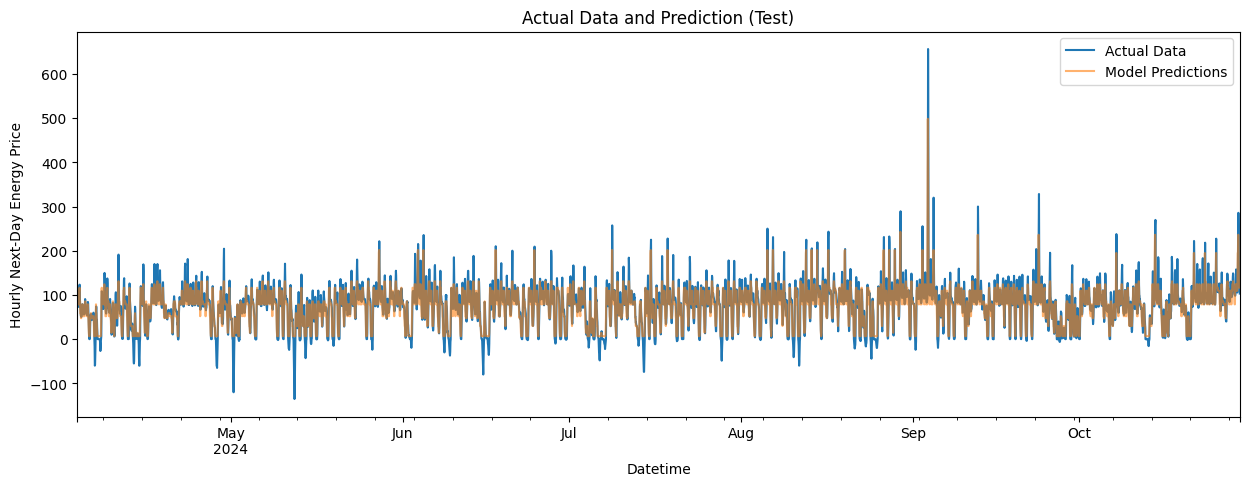

In [2141]:
WINDOW = df.iloc[:int(0.06 * (len(df)))].copy()

ax = WINDOW[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='-', alpha=0.6)
ax.set_xlim(WINDOW.index.min(), WINDOW.index.max())
ax.set_ylabel("Hourly Next-Day Energy Price")
plt.legend(['Actual Data', 'Model Predictions'])    
ax.set_title('Actual Data and Prediction (Test)')
plt.show()

In [2142]:
#test error fot the entire test set
score = root_mean_squared_error(test[TARGET], test['prediction'])
print(f'RMSE Score on Test set: {score:.2f}')

RMSE Score on Test set: 19.50


In [2143]:
#days and (absolute) error realtion
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean()

date
2023-02-08     5.945549
2023-02-09    16.025518
2023-02-10    16.181225
2023-02-11    10.223459
2023-02-12    16.191806
                ...    
2024-10-25    12.374174
2024-10-26    11.419893
2024-10-27    10.610274
2024-10-28    10.701822
2024-10-29    22.782824
Name: error, Length: 630, dtype: float64

autml gridsearch autoscikit-learn